# Energy production & consumption forecast

This project compiles many time series forecasting models and compares their performances. The models introduced are :

*   ARIMA
*   ARIMAX
*   Prophet (Facebook)
*   LSTM
*   Chronos (Amazon)

Done using the Our World in Data Energy dataset : https://github.com/owid/energy-data?tab=readme-ov-file


## Imports & prerequisits

In [109]:
!git clone https://github.com/theophile-bb/Time-series-predictions-on-energy-production.git

Cloning into 'Time-series-predictions-on-energy-production'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 73 (delta 30), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 242.29 KiB | 4.18 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [110]:
%cd Time-series-predictions-on-energy-production

/content/Time-series-predictions-on-energy-production/Time-series-predictions-on-energy-production/Time-series-predictions-on-energy-production


In [111]:
pip install -r requirements.txt

In [112]:
import sys
sys.path.append("src")

In [113]:
# Utils

from utils import *

In [114]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [115]:
path = "data/energy_sample.json"

Connect the drive

***

Let's start by reading the data from the json and putting the dataframe into shape :

In [116]:
data = load_json(path)

In [117]:
df = create_df(data)

In [118]:
df.head()

,region,year,population,gdp,coal_prod_per_capita,coal_production,gas_prod_per_capita,gas_production,oil_prod_per_capita,oil_production,coal_prod_change_pct,coal_prod_change_twh,gas_prod_change_pct,gas_prod_change_twh,oil_prod_change_pct,oil_prod_change_twh,coal_cons_per_capita,coal_consumption,coal_share_energy,energy_per_capita,energy_per_gdp,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_energy,gas_consumption,gas_energy_per_capita,gas_share_energy,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_energy,low_carbon_consumption,low_carbon_energy_per_capita,low_carbon_share_energy,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_energy,oil_consumption,oil_energy_per_capita,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewables_elec_per_capita,other_renewables_energy_per_capita,other_renewables_share_energy,primary_energy_consumption,renewables_consumption,renewables_energy_per_capita,renewables_share_energy,coal_cons_change_pct,coal_cons_change_twh,energy_cons_change_pct,energy_cons_change_twh,fossil_cons_change_pct,fossil_cons_change_twh,gas_cons_change_pct,gas_cons_change_twh,hydro_cons_change_pct,hydro_cons_change_twh,low_carbon_cons_change_pct,low_carbon_cons_change_twh,nuclear_cons_change_pct,nuclear_cons_change_twh,oil_cons_change_pct,oil_cons_change_twh,other_renewables_cons_change_pct,other_renewables_cons_change_twh,renewables_cons_change_pct,renewables_cons_change_twh,low_carbon_elec_per_capita,low_carbon_electricity,renewables_elec_per_capita,renewables_electricity,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_energy,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_energy,solar_cons_change_pct,solar_cons_change_twh,wind_cons_change_pct,wind_cons_change_twh,coal_elec_per_capita,coal_electricity,coal_share_elec,electricity_generation,electricity_share_energy,fossil_elec_per_capita,fossil_electricity,fossil_share_elec,gas_elec_per_capita,gas_electricity,gas_share_elec,hydro_share_elec,low_carbon_share_elec,nuclear_share_elec,oil_elec_per_capita,oil_electricity,oil_share_elec,other_renewables_share_elec,per_capita_electricity,renewables_share_elec,solar_share_elec,wind_share_elec,biofuel_cons_per_capita,biofuel_consumption,biofuel_share_energy,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,carbon_intensity_elec,electricity_demand,greenhouse_gas_emissions,net_elec_imports,net_elec_imports_share_demand,other_renewable_exc_biofuel_electricity,other_renewables_elec_per_capita_exc_biofuel,other_renewables_share_elec_exc_biofuel
0,United States,1900,74829905,6.139981e+11,24447.376953,1829.394897,986.776917,73.840424,1318.265259,98.645660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,1901,76245912,6.831060e+11,26094.421875,1989.593018,1073.212524,81.828064,1411.233154,107.600761,8.756887,160.198120,10.817432,7.98764,9.078050,8.955101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,1902,7769

***

## Production Data

The goal here is to proceed manualy to try and forecast the production for one of the energy sources.

To do so we'll try multiple forecasting models and see how they perform to forecast with our data.

As a starter we'll begin by sticking to only the USA and we'll study the oil, gas and coal productions since year 1900.

In [119]:
countries = ["United States"]
col = ['region', 'coal_production', 'oil_production', 'gas_production']

dfCountry = get_countries(df, countries)
dfProduction = get_columns(dfCountry, col)

/content/Time-series-predictions-on-energy-production/src/utils.py:85: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



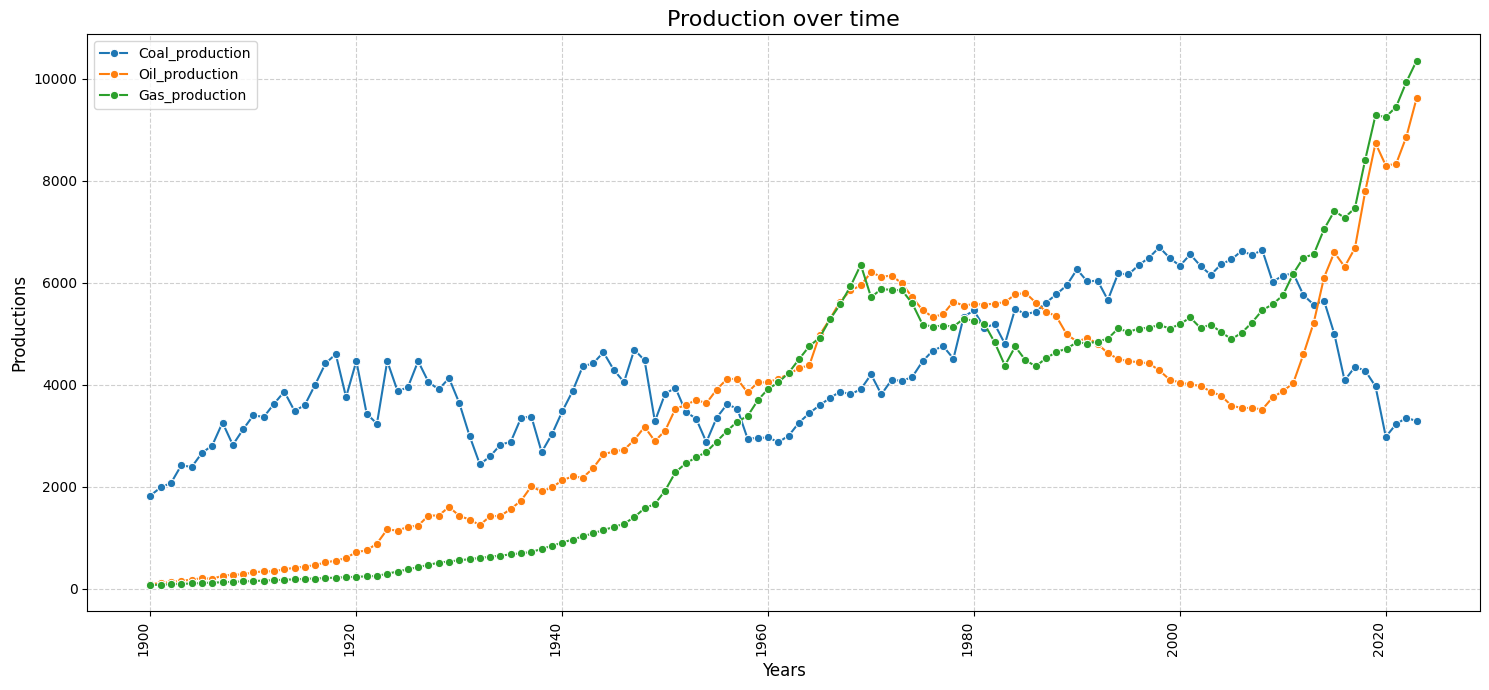

In [120]:
plot_graph(dfProduction,"Production over time")

### ARIMA

The ARIMA models combine two models and one method. These are:

*   Auto Regression(AR)
*   Moving Average(MA)
*   Differencing for stationarity(I)

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms(AR), d is the number of nonseasonal differences needed for stationarity(I), and q is the number of lagged forecast errors in the prediction equation(MA).

One of the preprocessing steps is to determine the optimal orders **(p, d, q)** of our ARIMA model. The simplest one is the order of differencing d as this can be verified by carrying out a statistical test for stationarity. The most popular one is the Augmented Dickey-Fuller (ADF), where the null hypothesis is that the time series is not stationary.

d refers to the number of differencing transformations required by the time series to get stationary. So we can use pandas 'diff()' function once or more and recall stationarity function to find the d-value.  If the P-value of Dickey-Fuller test is less than 0.05, the column is stationary, otherwise it is not stationary.

In [121]:
col = 'coal_production'

The function stationarity will ease the process by returning d (number of differenciations) and the associated P-value.

In [122]:
diff_col, d = stationarity(dfProduction[col])


Test Statistic: -5.980681415167907
P-Value: 1.841703383077842e-07
Stationary


The autoregressive and moving-average orders (p,q) can be deduced by analysing the partial autocorrelation function (PACF) and autocorrelation function respectively. The gist of of this method is to plot a correlogram of the various lags/forecast errors of the time series to determine which are statistically significant.

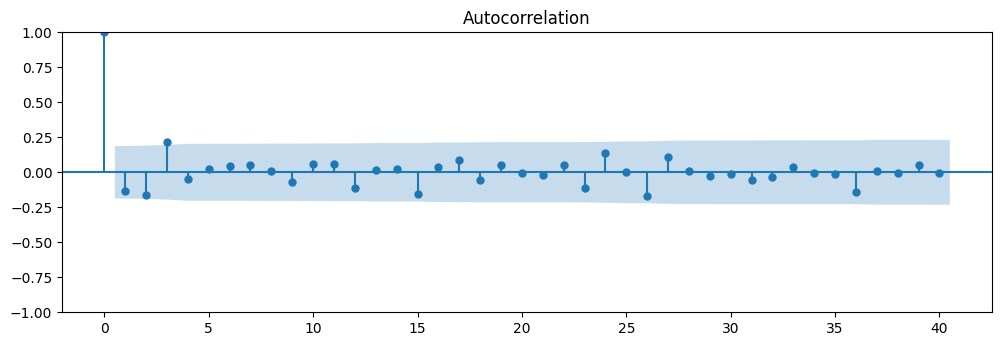

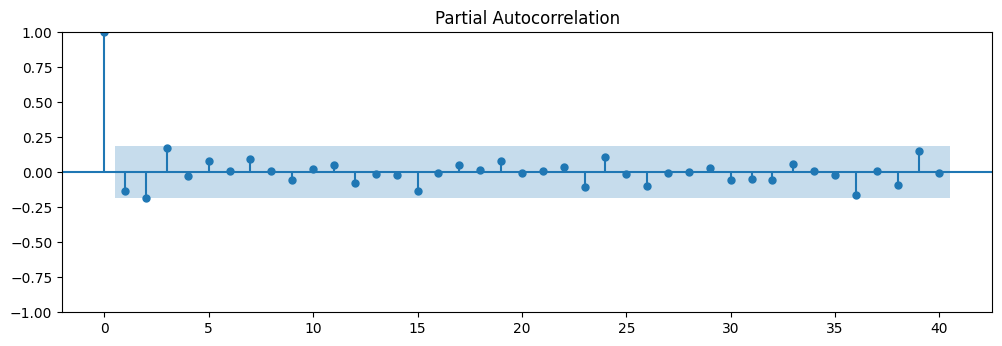

In [123]:
plot_acf(diff_col)
plot_pacf(diff_col)

We can use the Autocorrelation plot to get q and the Partial Autocorrelation one to get p.

We then split our dataset into training and testing set :

In [124]:
train, test = split_data(dfProduction, 0.8)

We define the model with the parameters p, d, q. If p and q are equal to 0 it gives us an ARIMA(0, 1, 0). It then becomes an ARMA(0, 0) when differenced, which is random, uncorrelated, noise (random walk). The sum of noise terms has a mean of 0 : the expected position is still the starting point, but the variance around it increases over time.

In [125]:
model_fit = train_ARIMA(train, col, 0,d,0)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



We use the model to forecast on the test set

In [126]:
testForecast = predict_ARIMA(model_fit, test)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/content/Time-series-predictions-on-energy-production/src/utils.py:183: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Finally we can plot the predictions on the test set and compare it with the actual ones :

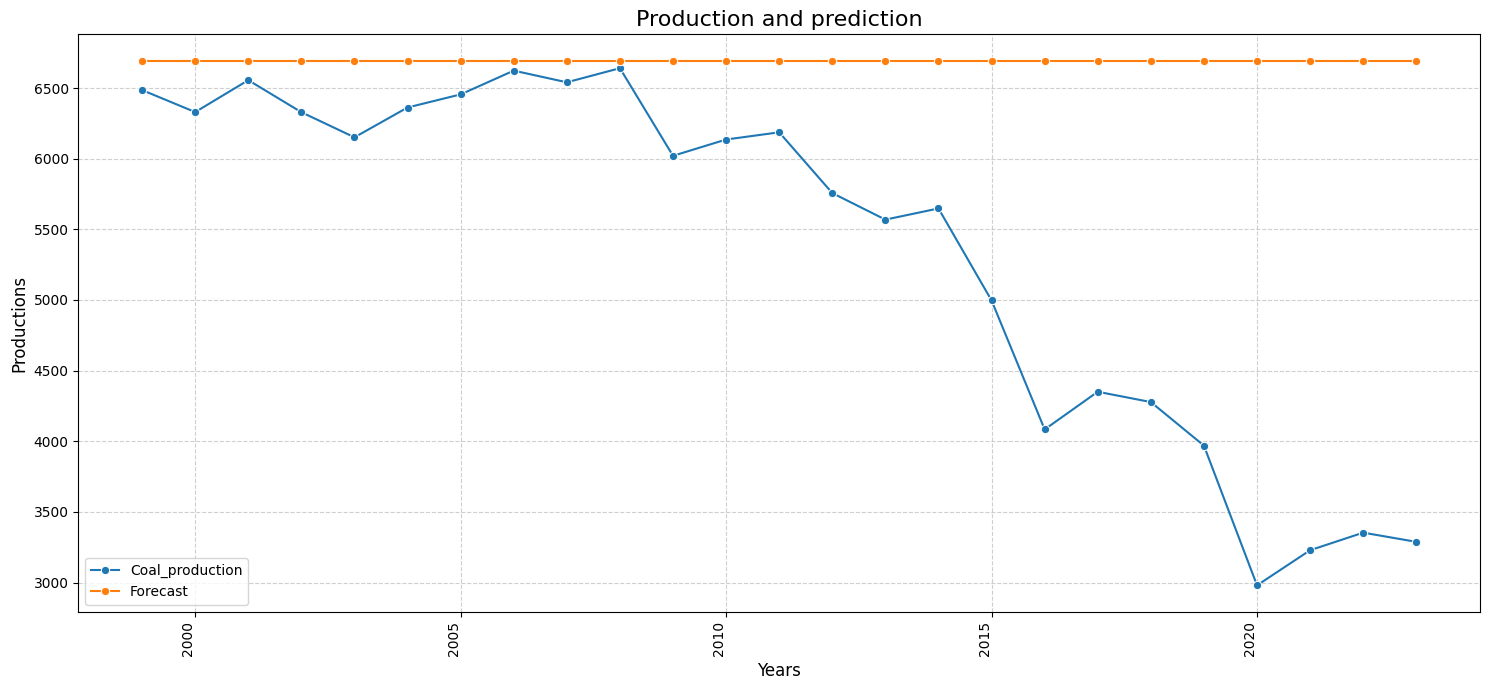

In [128]:
plot_graph(test,"Production and prediction", ['coal_production','forecast'])

Note : We can also use auto_arima to find the optimal p, d, q for our model, which we will use in the coming part : ARIMAX.

***

### ARIMAX

The **ARIMAX (AutoRegressive Integrated Moving Average with Exogenous Variables)** model is an extension of ARIMA that incorporates exogenous variables (X variables) to improve forecasting accuracy. It is a good model to use when there is an external factor (exogenous variable) influencing the time series.

First we'll test the model by training it on a training set and testing it with a test set. We are going to partition both the endogenous and exogenous values.

In [74]:
endogCol = col
exogCol = ['gdp', 'population', 'primary_energy_consumption', 'oil_production', 'gas_production']

endog, exog = initialize_endog_exog(dfCountry,endogCol, exogCol)

In [75]:
endog_train, endog_test = split_data(endog, 0.8)
exog_train, exog_test = split_data(exog, 0.8)

model = train_SARIMAX(endog_train, exog_train)

results = predict_SARIMAX(model, exog_test, len(exog_test))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1450.865, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1448.906, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1447.336, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1450.450, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1449.022, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1448.383, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1446.412, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1446.895, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1447.517, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1446.663, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1445.036, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1446.573, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1446.926, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1446.253, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be gi

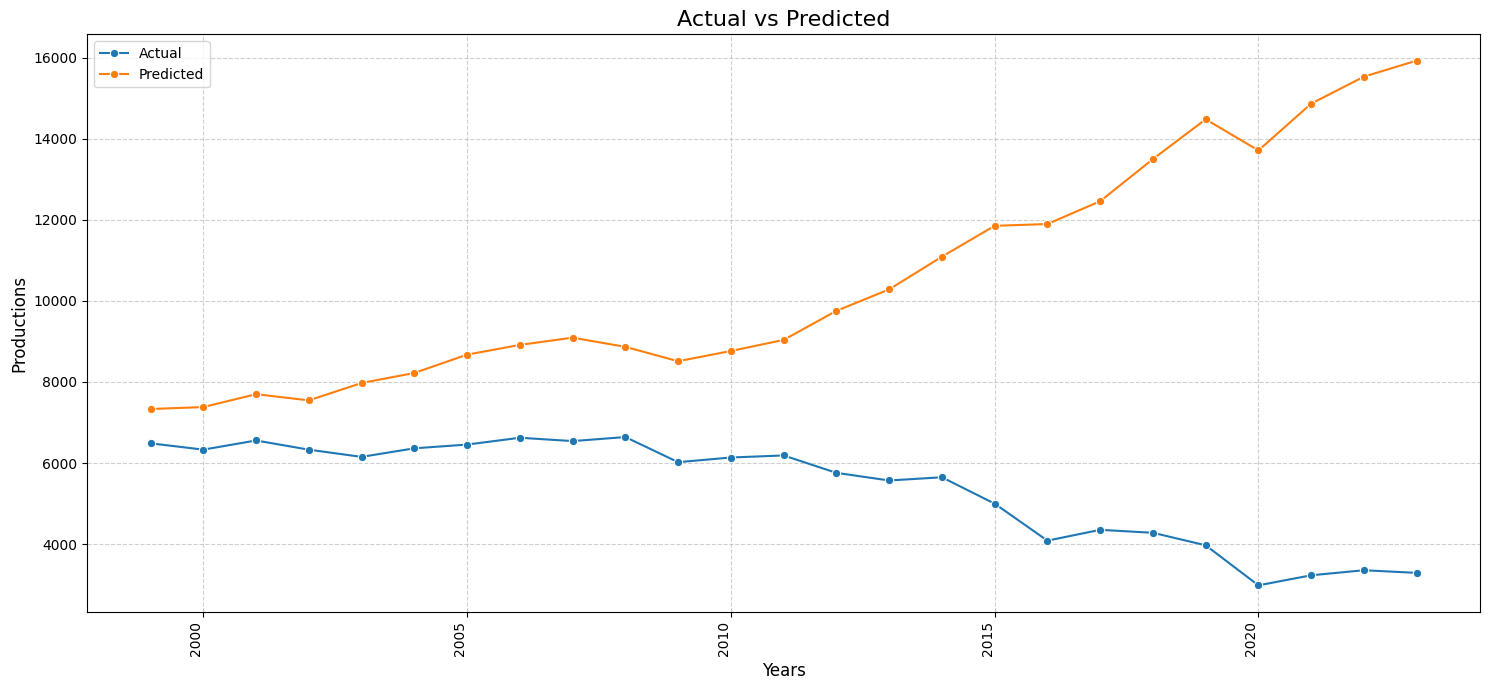

In [76]:
results_df = pd.DataFrame(data={'actual': list(endog_test), 'predicted': list(results)}, index=endog_test.index)

plot_graph(results_df,"Actual vs Predicted", ['actual','predicted'])

We are now going to try and predict the future values for the coming years. To do so we'll need the exogenous values for these years.

We are going to approximate each of the future exogneous values (column) by using a simple linear regression with polynomial features. This model isn't optimal but it is quite simple and very well fitting for values with an exponential growth such as 'gdp' or 'population'.

Note that we use the **ReLu (Rectified Linear Unit)** function to prevent negative predictions.

In [77]:
exog_pred = predict_exog(exog)

Now that we have our predicted exogenous values we can train the ARIMAX with the endogenous and exogenous values and then predict using the predicted exogenous values.

In [78]:
model = train_SARIMAX(endog, exog)

results = predict_SARIMAX(model, exog_pred, len(exog_pred))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1819.048, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1818.744, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1818.116, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1817.163, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1819.871, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.650 seconds
Optimal p, d, q: (0, 1, 0)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In

In [79]:
data_plot = format_data_plot(endog)
forecast_plot = format_forecast_plot(results, dfProduction, len(results))

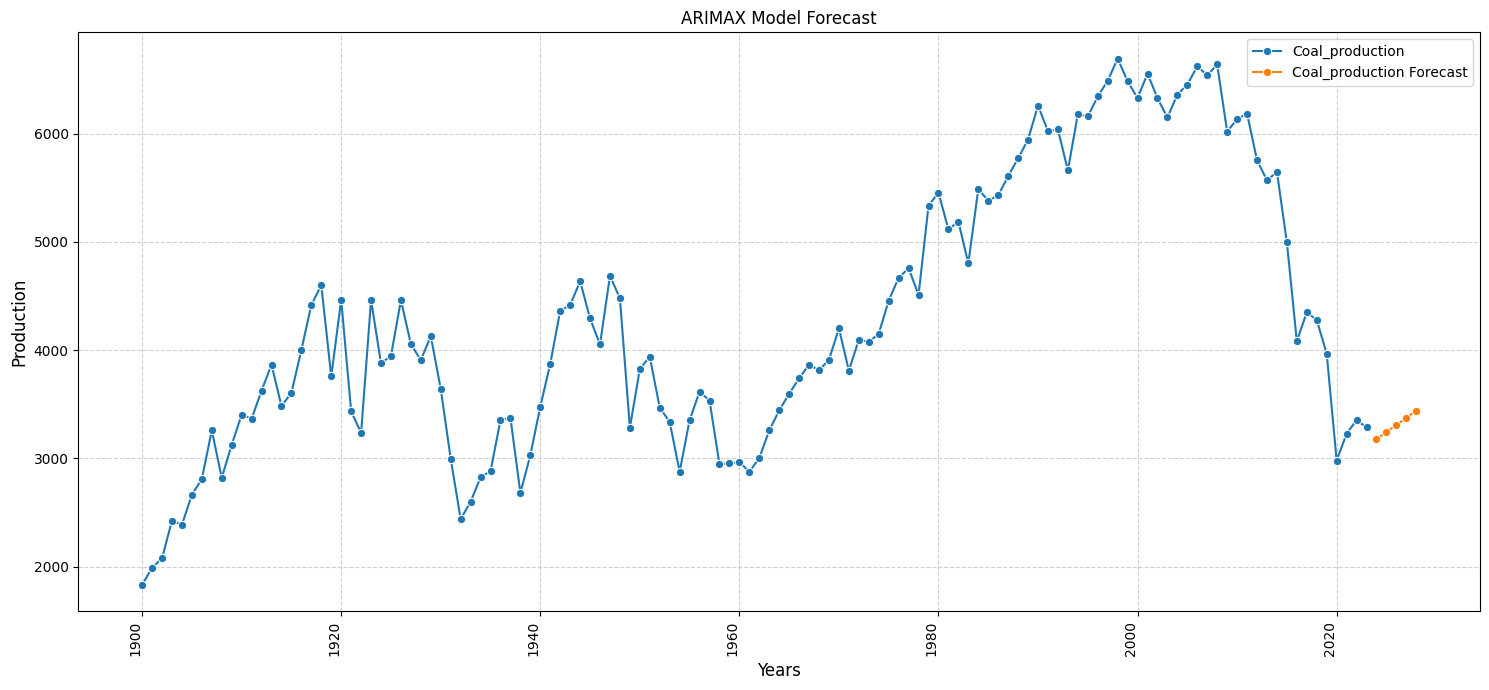

In [80]:
plot_forecasts(data_plot, forecast_plot, col)

***

### Prophet

Prophet is an additive time series forecasting model that’s designed to work well with data that has:

*   Seasonality (daily, weekly, yearly patterns).
*   Trends (growth, decline, plateaus).
*   Holidays/Special Events (big spikes or dips).

It’s built to be robust to missing data and outliers, which is a common headache with other models.

In [81]:
prophet_df = format_Prophet(dfCountry, col)

We disable seasonality because we have no use of it.

In [82]:
period = 10

model = fit_Prophet(prophet_df)
results = predict_Prophet(model,period)

In [83]:
results

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1900-01-01,2845.609442,1750.571932,3955.116028,2845.609442,2845.609442,0.0,0.0,0.0,0.0,0.0,0.0,2845.609442
1,1901-01-01,2869.156073,1766.573981,4062.915845,2869.156073,2869.156073,0.0,0.0,0.0,0.0,0.0,0.0,2869.156073
2,1902-01-01,2892.702704,1792.482740,4098.064579,2892.702704,2892.702704,0.0,0.0,0.0,0.0,0.0,0.0,2892.702704
3,1903-01-01,2916.249334,1736.419800,3961.800243,2916.249334,2916.249334,0.0,0.0,0.0,0.0,0.0,0.0,2916.249334
4,1904-01-01,2939.795965,1892.527012,4114.680399,2939.795965,2939.795965,0.0,0.0,0.0,0.0,0.0,0.0,2939.795965
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2028-12-31,5873.791841,4672.933536,7112.665367,5873.727157,5873.869607,0.0,0.0,0.0,0.0,0.0,0.0,5873.791841
130,2029-12-31,5896.994684,4669.307354,6983.487387,5896.905086,5897.099161,0.0,0.0,0.0,0.0,0.0,0.0,5896.994684
131,2030-12-31,5920.197528,4796.531831,7138.433752,5920.084250,5920.329945,0.0,0.0,0.0,0.0,0.0,0.0,5920.197528
132,2031-12-31,5943.400371,4650.043271,7159.162781,5943.260792,5943.567768,0.0,0.0,0.0,0.0,0.0,0.0,5943.400371


We can try to predict for the next 10 years :

In [84]:
data_plot = format_data_plot(dfProduction[col])
forecast_plot = format_Prophet_plot(dfProduction, results, period)

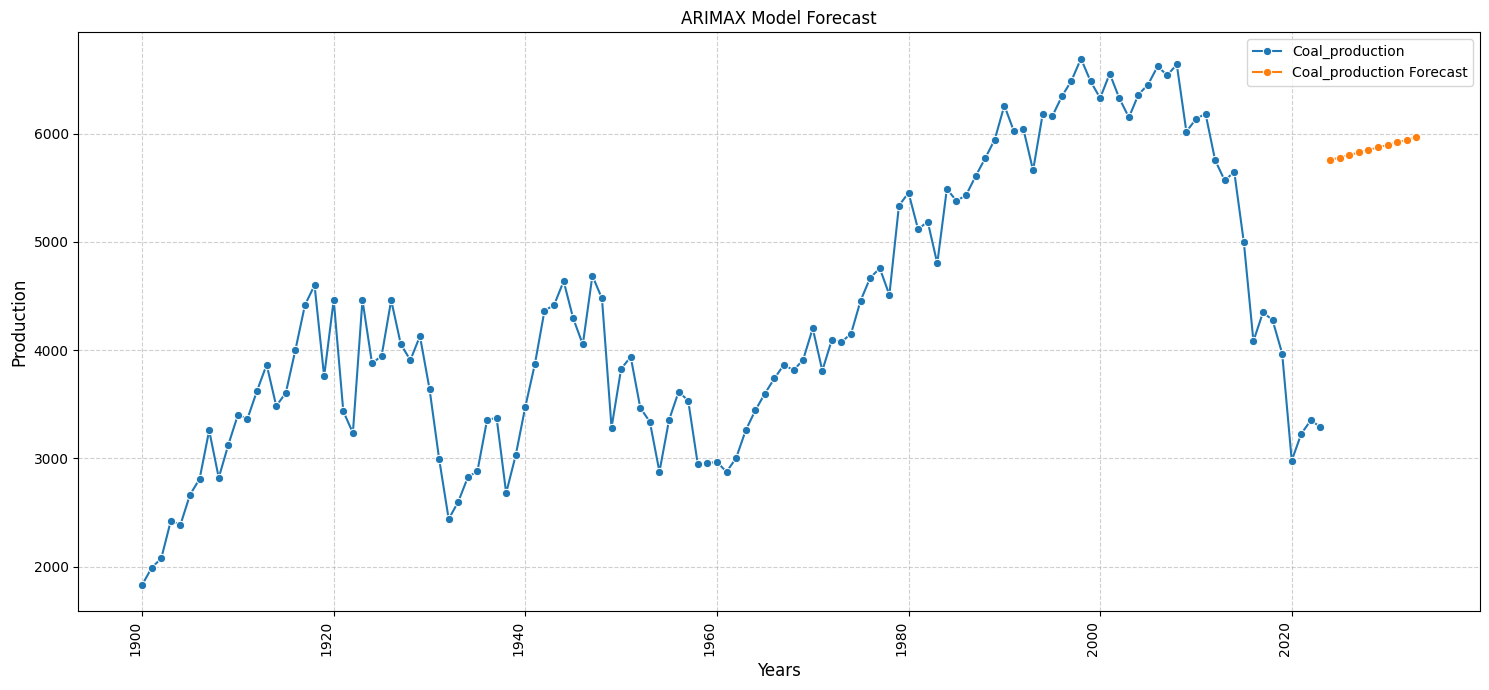

In [85]:
plot_forecasts(data_plot, forecast_plot, col)

***

## LSTM

Long Short-Term Memory is a type of Recurrent Neural Network (RNN). LSTM learns from past values and patterns directly which makes it good when past values influence future values.

Regular RNNs struggle with long-term dependencies whereas the LSTM has a memory cell that helps retain information over long periods.

It decides what to remember and what to forget using three gates:

*   Forget Gate	: Decides what past info to forget.
*   Input Gate : Decides what new info to store.
*   Output Gate	: Decides what to output based on memory.

LSTM remembers long-term trends but adapts when patterns change.

###  Multi-step-ahead forecast

We predict multiple future steps directly on the entire horizon (e.g., next 5 years) at once.

In [86]:
  scaled_data, scaler = scale_data(dfProduction, col)
  train, test = split_data(scaled_data, 0.8)

In [87]:
seq_length = 3
horizon = 10

In [88]:
model = fit_LSTM(train, test, seq_length, horizon)

results = flatten_prediction(scaled_data, seq_length, model, scaler)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.2239 - val_loss: 0.5235
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2219 - val_loss: 0.5037
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2115 - val_loss: 0.4840
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2039 - val_loss: 0.4646
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1944 - val_loss: 0.4449
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1929 - val_loss: 0.4248
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1806 - val_loss: 0.4043
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1684 - val_loss: 0.3833
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1440 - val_loss: 0.3616
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1411 - val_loss: 0.3388
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1400 - val_loss: 0.3151
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1324 - val_loss: 0.2905


In [35]:
data_plot = format_data_plot(dfProduction[col])
forecast_plot = format_forecast_plot(results, dfProduction, len(results))

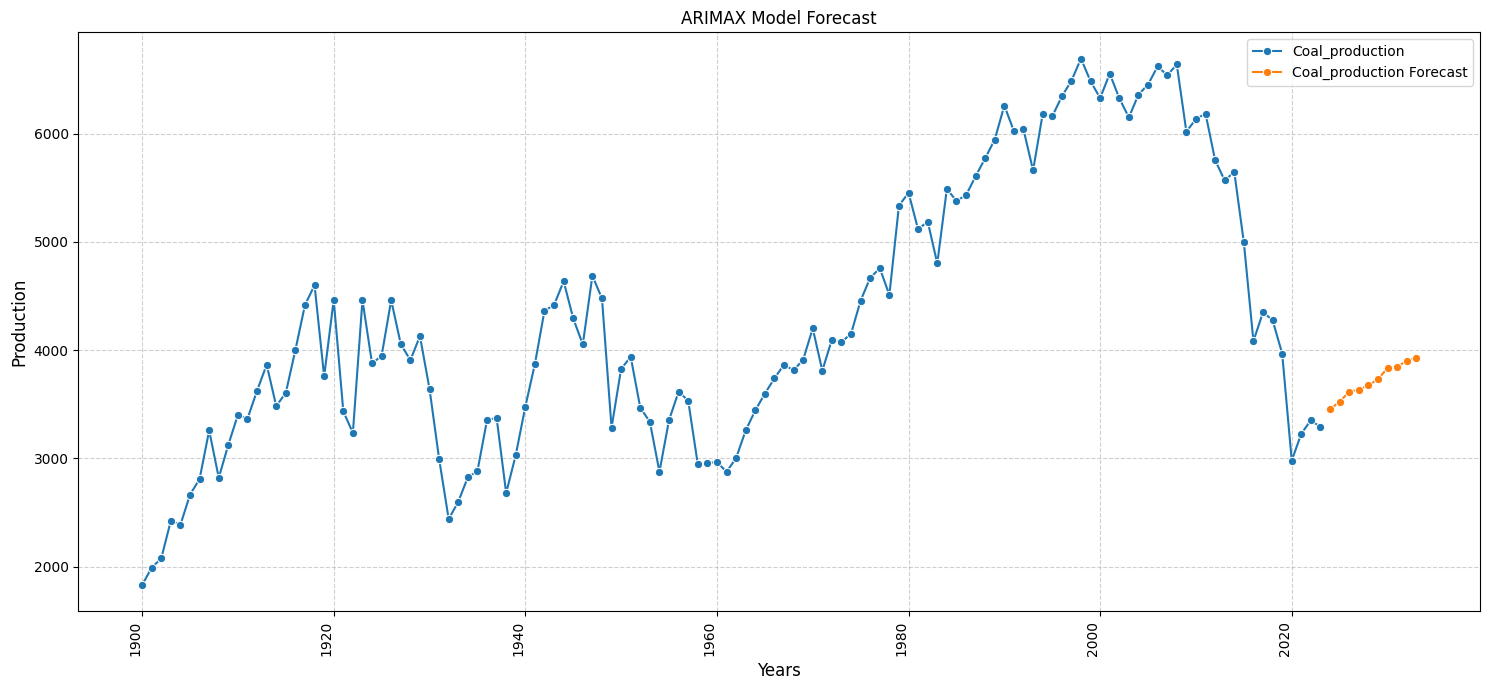

In [36]:
plot_forecasts(data_plot, forecast_plot, col)

***

### Chronos Bolt

# *Note : Requires Python 3.10 to work*

Chronos-Bolt is a family of pretrained time series forecasting models which can be used for zero-shot forecasting. It is based on the T5 encoder-decoder architecture and has been trained on nearly 100 billion time series observations. It chunks the historical time series context into patches of multiple observations, which are then input into the encoder. The decoder then uses these representations to directly generate quantile forecasts across multiple future steps—a method known as direct multi-step forecasting.

References :

https://huggingface.co/autogluon/chronos-bolt-small

https://github.com/amazon-science/chronos-forecasting/tree/main


Let's start by training a chronos with a train set and see its performances on a test set

In [167]:
ChronosData = format_Chronos(dfProduction, col)

train, test = split_data(ChronosData, 0.8)

period = len(test)
model = fit_Chronos(train, period)

print(ChronosData.index.get_level_values("timestamp").freq)

results_train = predict_Chronos(model, train)

Beginning AutoGluon training...
AutoGluon will save models to '/content/Time-series-predictions-on-energy-production/Time-series-predictions-on-energy-production/Time-series-predictions-on-energy-production/AutogluonModels/ag-20251224_134311'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Pytorch Version:    2.9.0+cpu
CUDA Version:       CUDA is not available
GPU Memory:         
Total GPU Memory:   Free: 0.00 GB, Allocated: 0.00 GB, Total: 0.00 GB
GPU Count:          0
Memory Avail:       10.74 GB / 12.67 GB (84.8%)
Disk Space Avail:   85.40 GB / 107.72 GB (79.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'autogluon/chronos-bolt-small'}},
 'known_covariates_names': [],
 'num_val_windows': 

None


In [168]:
test['forecast'] = results_train['mean']
test["year"] = test.index.get_level_values("timestamp").year
test = test.reset_index()

/tmp/ipython-input-2973070578.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2973070578.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



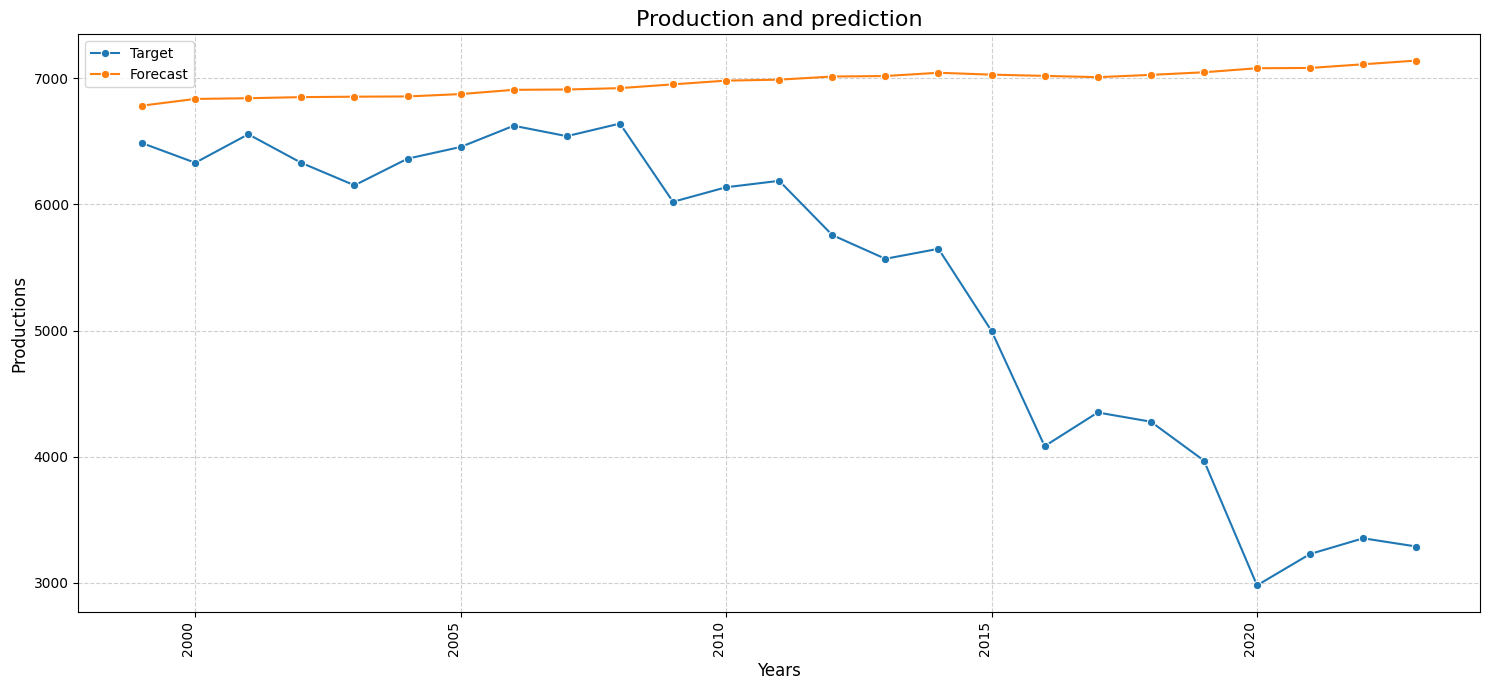

In [170]:
plot_graph(test,"Production and prediction", ['target','forecast'])

Then we can forecast for future years

In [91]:
period = 10
model = fit_Chronos(ChronosData, period)
results = predict_Chronos(model, ChronosData)

Beginning AutoGluon training...
AutoGluon will save models to '/content/Time-series-predictions-on-energy-production/Time-series-predictions-on-energy-production/AutogluonModels/ag-20251224_131427'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Pytorch Version:    2.9.0+cpu
CUDA Version:       CUDA is not available
GPU Memory:         
Total GPU Memory:   Free: 0.00 GB, Allocated: 0.00 GB, Total: 0.00 GB
GPU Count:          0
Memory Avail:       10.80 GB / 12.67 GB (85.3%)
Disk Space Avail:   85.40 GB / 107.72 GB (79.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'autogluon/chronos-bolt-small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_level

In [93]:
data_plot = format_data_plot(dfProduction[col])
forecast_plot = format_forecast_plot(results['mean'], dfProduction, period)

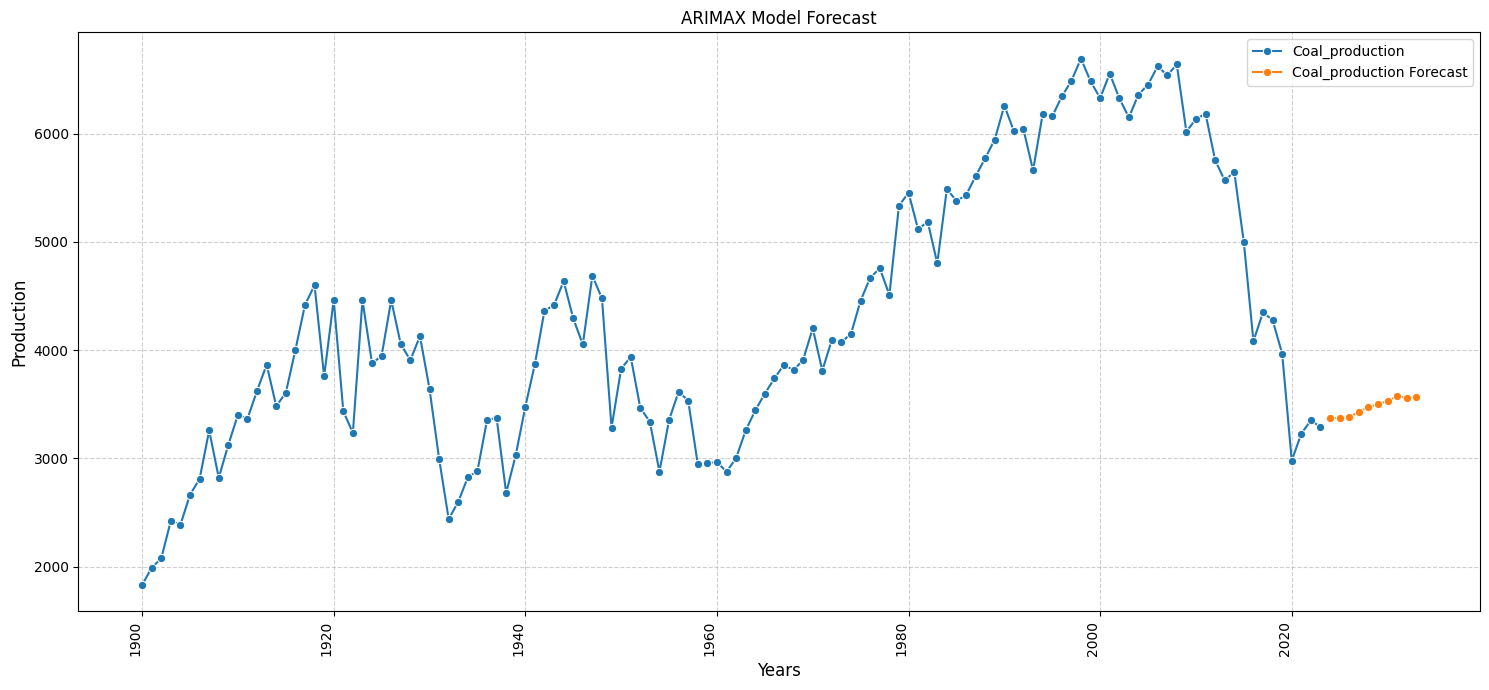

In [94]:
plot_forecasts(data_plot, forecast_plot, col)

***